In [1]:
import sklearn
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [2]:
ls -l "C:/Users/sora4/Python Code/Neural_Network_forward_and_back/"

 Volume in drive C has no label.
 Volume Serial Number is 8EAE-8C16

 Directory of C:\Users\sora4\Python Code\Neural_Network_forward_and_back


 Directory of C:\Users\sora4\Python Code\Neural_Network_forward_and_back

07/08/2018  09:28 PM    <DIR>          .
07/08/2018  09:28 PM    <DIR>          ..
07/08/2018  12:53 PM    <DIR>          .idea
07/08/2018  06:15 PM    <DIR>          .ipynb_checkpoints
06/17/2014  08:37 PM           392,564 ex4.pdf
06/17/2014  08:37 PM         7,511,764 ex4data1.mat
06/17/2014  08:37 PM            79,592 ex4weights.mat
06/17/2014  08:37 PM               268 ml_login_data.mat
07/08/2018  08:45 PM            81,208 Neural Networks.ipynb
07/08/2018  09:28 PM                24 README.md
               6 File(s)      8,065,420 bytes
               4 Dir(s)  331,216,986,112 bytes free


In [3]:
data = io.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]

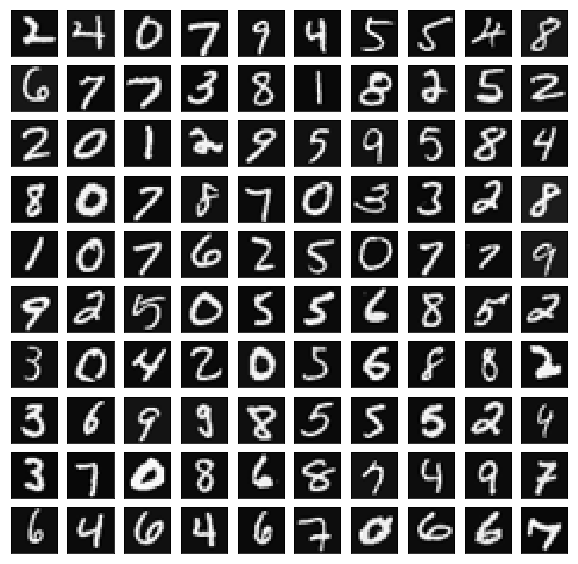

In [4]:
def plot_data():
    sample = np.random.choice(range(0, X.shape[0]), size= 100).flatten()
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.reshape(X[sample[i], :], (20, 20)).T, cmap="gray")
        ax.set(xticks=[], yticks=[])
plot_data()

In [5]:
def add_ones_column_to_X(X):
    new_X = np.ones((X.shape[0], X.shape[1] + 1))
    new_X[:, 1:] = X
    return new_X
X_ready = add_ones_column_to_X(X)
X_ready.shape

(5000, 401)

In [6]:
ex4_weights = io.loadmat("ex4weights.mat")
theta1_pre = ex4_weights["Theta1"]
theta2_pre = ex4_weights["Theta2"]
theta1_pre.shape

(25, 401)

In [12]:
from scipy.special import expit
def h(theta, X, y):
    """
    Theta will be a list of arrays,
    each array will be another theta
    for the system.
    """
    print()
    
    activation_vals = add_ones_column_to_X(X)
    
    for next_theta in theta:
        print(type(theta))
        z = theta.dot(activation_vals)
        # Expit is the g function
        activation_vals = expit(z)
        # Add the ones
        
        
    return activation_vals
        
def nnCostFunction():
    pass

theta_whole = [theta1_pre, theta2_pre]
print(type(theta1_pre))
print(type(theta_whole[0]))
h(theta_whole, X, y)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


AttributeError: 'list' object has no attribute 'dot'